In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import mysql.connector

In [2]:
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Garim@2001",
                            database = "sql_and_python")

cur = db.cursor()

## 1. List all unique cities where customers are located.

In [3]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Customer_City'])

df.head()

,Customer_City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## 2. Count the number of orders placed in 2017

In [4]:
query = """ select count(order_id) from orders where year (order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 135303)

## 3. Find the total sales per category

In [5]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2)
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category','Sales'])

df.head()

,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,FASHION BAGS AND ACCESSORIES,1745266.24
4,BED TABLE BATH,13700429.37


## 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end)) / count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

## 5. Count the number of customers from each state.

In [7]:
query = """ select customer_state , count(customer_id)
from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['State' , 'Num_Customers'])

df.head()

,State,Num_Customers
0,SP,125238
1,SC,10911
2,MG,34905
3,PR,15135
4,RJ,38556


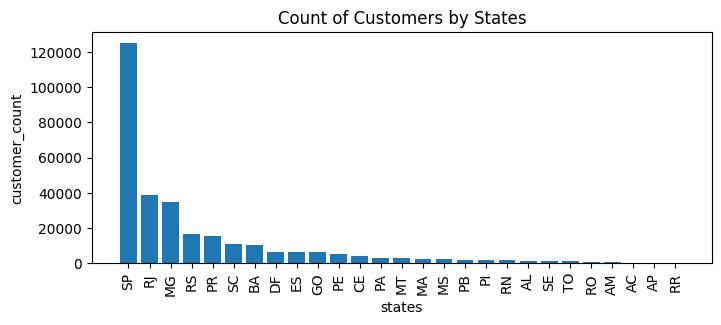

In [8]:
df = df.sort_values(by = "Num_Customers", ascending= False)
plt.figure(figsize = (8,3))
plt.bar(df["State"], df["Num_Customers"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

## 6. Calculate the number of orders per month in 2018.

In [9]:
query = """select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Month' , 'Num_Orders'])

df.head()

,Month,Num_Orders
0,July,18876
1,August,19536
2,February,20184
3,June,18501
4,March,21633


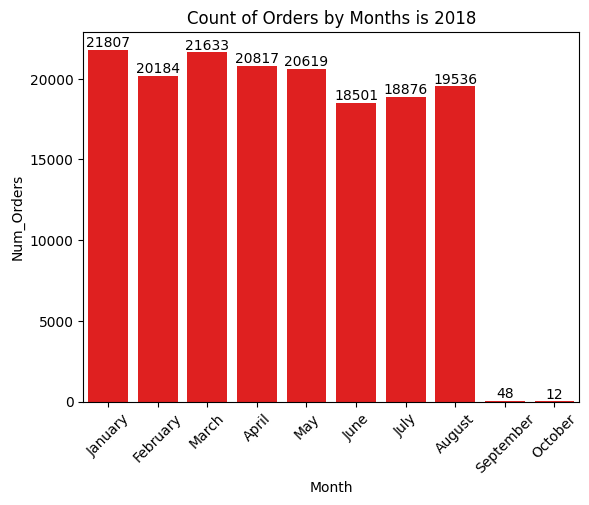

In [10]:
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["Month"],y =  df["Num_Orders"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

## 7. Find the average number of products per order, grouped by customer city.

In [11]:
query = """ with count_per_order as
(select orders.order_id , orders.customer_id ,
count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)

select customers.customer_city , round(avg(count_per_order.oc) , 2) as average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["customer city", "average products/order"])

df.head(10)

,customer city,average products/order
0,treze tilias,7.64
1,indaial,6.69
2,sao jose dos campos,6.83
3,sao paulo,6.94
4,porto alegre,7.05
5,santos,6.97
6,sao francisco do sul,7.41
7,sao vicente,6.55
8,joinville,6.62
9,sao vendelino,6.00


## 8. Calculate the percentage of total revenue contributed by each product category

In [12]:
query = """ select upper(products.product_category) category,
round((sum(payments.payment_value) / (select sum(payment_value) from payments))*100,2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
order by sales desc
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category' , 'Total_Revenue_Contributed'])

df.head()

,Category,Total_Revenue_Contributed
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71


## 9. Identify the correlation between product price and the number of times a product has been purchased.

In [13]:
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


## 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [14]:
query = """ select * , dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id,
sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Seller_id' , 'Total_Revenue_Generated' , 'Rank'])
df.head()

,Seller_id,Total_Revenue_Generated,Rank
0,7c67e1448b00f6e969d365cea6b010ab,2.028668e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1.232888e+06,2
2,4a3ca9315b744ce9f8e9374361493884,1.204981e+06,3
3,1f50f920176fa81dab994f9023523100,1.161014e+06,4
4,53243585a1d6dc2643021fd1853d8905,1.139612e+06,5


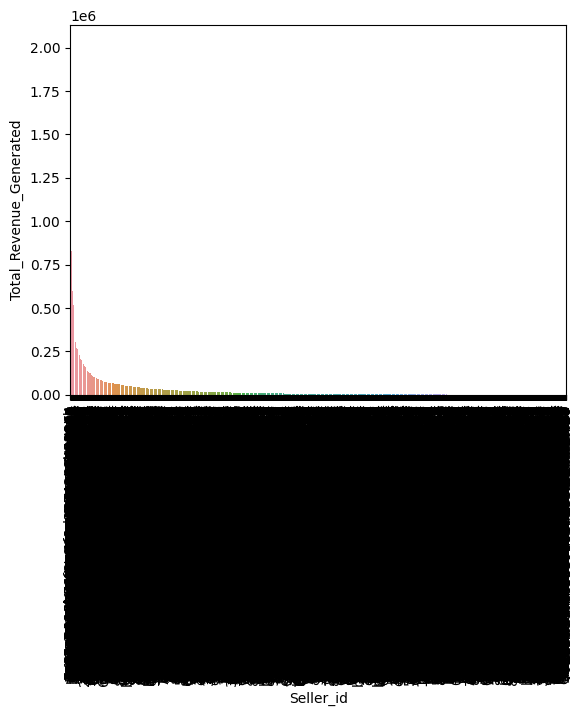

In [15]:
sns.barplot(x = "Seller_id", y = "Total_Revenue_Generated", data = df)
plt.xticks(rotation = 90)
plt.show()

## 11. Calculate the moving average of order values for each customer over their order history.

In [16]:
query = """ select customer_id , order_purchase_timestamp , payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id , orders.order_purchase_timestamp,
payments.payment_value as payment 
from payments join orders 
on payments.order_id = orders.order_id) as a"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data,columns = ["Customer_id", "order_purchase_timestamp","payment","moving_avg"])

df.head()

,Customer_id,order_purchase_timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


## 12. Calculate the cumulative sales per month for each year.

In [17]:
query = """ select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments 
on orders.order_id = payments.order_id
group by years , months order by years, months) as a"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data,columns = ["Years", "Months","Payment","Cumulative_sales"])

df.head()

,Years,Months,Payment,Cumulative_sales
0,2016,9,1513.44,1513.44
1,2016,10,354542.88,356056.32
2,2016,12,117.72,356174.04
3,2017,1,830928.24,1187102.28
4,2017,2,1751448.06,2938550.34


## 13. Calculate the year-over-year growth rate of total sales.

In [18]:
query = """
WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years 
    ORDER BY years
)
SELECT 
    years, 
    payment, 
    ((payment - LAG(payment, 1) OVER(ORDER BY years)) /
    LAG(payment, 1) OVER(ORDER BY years)) * 100 AS yoy_growth_percentage
FROM a;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["Years", "Sales", "YoY Growth Percentage"])

df.head()

,Years,Sales,YoY Growth Percentage
0,2016,356174.04,NaN
1,2017,43498480.37,12112.703759
2,2018,52198578.31,20.000924


## 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [19]:
query = """ with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

## 15. Identify the top 3 customers who spent the most money in each year.

In [20]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["years","id","payment","rank"])

df.head()

,years,id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,8541.300293,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,8404.439941,2
2,2016,4a06381959b6670756de02e07b83815f,7366.680176,3
3,2017,1617b1357756262bfa56ab541c47bc16,81984.480469,1
4,2017,c6e2731c5b391845f6800c97401a43a9,41575.860352,2


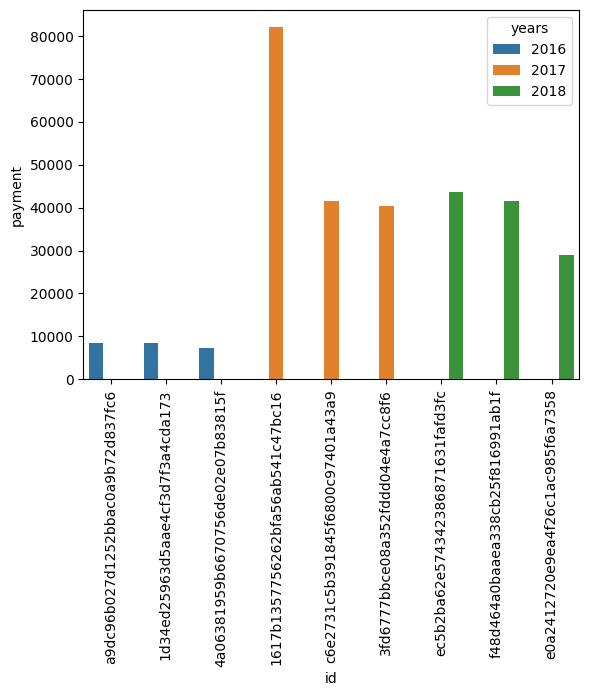

In [21]:
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()